### **Superposition, Interference, and Measurement**

Superposition and measurement are two of the most important ideas in quantum computing. To understand them, imagine a regular computer bit, which can only be in one state at a time—either 0 or 1. A quantum bit, or **qubit**, is different. It can be in a mix of both 0 and 1 at the same time. This special condition is called **superposition**. But the moment we try to observe or measure the qubit, it "collapses" into just one of the two possible states: either $\ket{0}$ or $\ket{1}$. One of the most famous experiments that shows this strange behavior is the **double-slit experiment**. It shows how particles like electrons can act like waves, passing through two slits at once and interfering with themselves—unless we try to detect which slit they went through. When we observe them, this interference disappears, and they behave like normal particles. Another example of this weird quantum behavior is the well-known **Schrödinger’s Cat** thought experiment, which also shows how measurement can change a system.
In this notebook, we’ll explore how particles behave in these kinds of experiments, both **with** and **without** measurement.


### **Young's Double Slit Experiment**

This famous experiment was first performed by [Thomas Young]( https://en.wikipedia.org/wiki/Thomas_Young_(scientist) ) in 1801. It demonstrates that light and matter exhibit the behavior of both classical particles and classical waves — a key idea in quantum mechanics known as **wave-particle duality**. The experiment falls under the class of *double-path experiments*, where a wave (such as light) is split into two paths using slits, and then the two resulting wavefronts combine on a screen to produce an **interference pattern** — alternating bright and dark fringes. This wave-like interference was well understood for light and water waves at the time, so it wasn’t surprising when done with beams of light. However, things became strange when the same experiment was repeated with **particles** like electrons, atoms, or even large molecules. If we throw particles one by one from a source and allow them to pass through either of the two slits without disturbing them or trying to detect which slit they went through, we surprisingly **still get an interference pattern**. This suggests that **each particle behaves like a wave**, interfering with itself as if it went through **both slits simultaneously** — a manifestation of quantum **superposition**. Now, if we place detectors at the slits to observe **which slit** each particle goes through, the interference pattern **disappears**. Instead, we see two distinct bands on the screen — the pattern we would expect from classical particles going through one slit or the other. This change in behavior upon observation is a direct example of **quantum measurement collapse**: by measuring the system, we force the particle to 'choose' a slit, thereby destroying its superposition state.

![Double Slit Experiment](images/image-5.png)

This experiment not only confirms the wave-particle duality of matter and light but also highlights the profound role of the observer in quantum mechanics. It shows that the **act of measurement itself affects the outcome**, a principle that challenges our classical intuition and forms the foundation of quantum theory. Lets do it!


In [2]:
from imports import *

### **Mapping**

To solve a classical problem using quantum computing, we must first **map the problem into a quantum circuit** that can be run on quantum hardware. This mapping step is crucial, as it translates classical concepts into quantum operations. In the context of the double-slit experiment, our goal is to simulate a particle passing through two slits — a setup that demonstrates quantum superposition and interference. To represent this using a qubit, we assign the quantum state $\ket{0}$ to the **lower slit**, and $\ket{1}$ to the **upper slit**. Initially, the qubit is in state $\ket{0}$, meaning the particle is at the source and hasn't passed through any slit yet. To simulate it passing through **both slits at once**, we apply a **Hadamard gate**, which puts the qubit into an equal superposition of $\ket{0}$ and $\ket{1}$:
$$
\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})
$$
This state represents a particle that is simultaneously passing through **both slits**, just like in the actual experiment. From here, we can further build the circuit to observe how quantum interference appears or disappears depending on whether we "measure" or "observe" which path the particle takes.

In the next section, we’ll construct this quantum circuit and explore its behavior using Qiskit primitives.


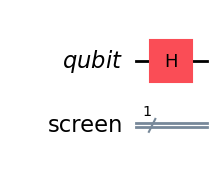

In [2]:
quantum_reg = QuantumRegister(1, name = "qubit")
classical_reg = ClassicalRegister(1, name = "screen")

double_slit = QuantumCircuit(quantum_reg, classical_reg)
# put our qubit in superposition by applying Hadamrd
double_slit.h(0)

double_slit.draw('mpl')

Next, we'll simulate how the particle behaves when it reaches the center of the screen, where the paths from both slits combine with no phase difference. We'll apply a Hadamard gate again to model this interference, then measure the qubit to observe the outcome. The result will be stored in a classical bit representing the screen.

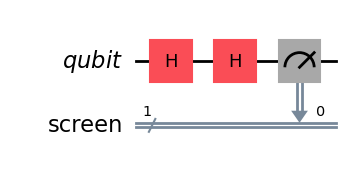

In [3]:
double_slit.h(quantum_reg[0])
double_slit.measure(quantum_reg[0], classical_reg[0])

double_slit.draw('mpl')

Now, Lets execute it on an ideal simulator.

In [4]:
backend = AerSimulator()

# We need to make our quantum circuit compatible to the backend
pass_manager = generate_preset_pass_manager(backend = backend, optimization_level=3)
compiled_circuit = pass_manager.run(double_slit)

# Now, we can run and get counts
sampler = Sampler(mode = backend)
counts = sampler.run([compiled_circuit], shots = 1000).result()[0].data.screen.get_counts()
print(counts)

{'0': 1000}


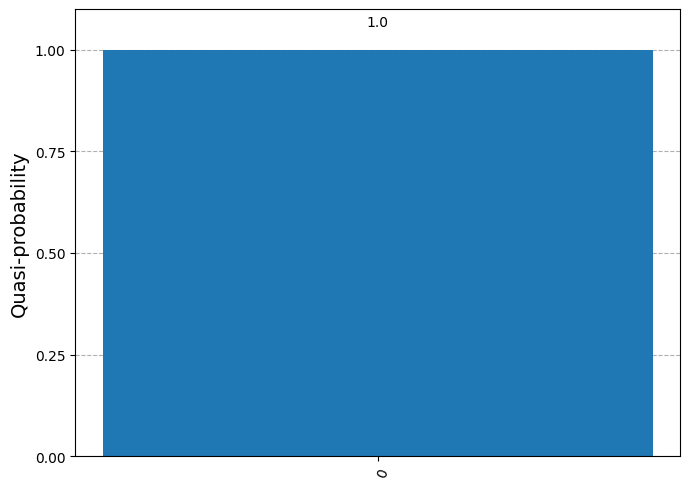

In [5]:
plot_distribution(counts)


Next, we'll simulate what happens when there is a **path difference** between the two slits. In quantum terms, this is represented by applying a **phase shift** to one of the components of the superposition. Specifically, we’ll apply a phase of $\pi/2$ (90°) to the $\ket{1}$ state of the qubit. This models the case where the upper slit introduces a slight delay compared to the lower slit, causing **constructive or destructive interference** to shift across the screen. We’ll observe how this phase difference affects the measurement results by extending our quantum circuit. In Qiskit, we can use a **phase gate** like `P` or `S` to apply this transformation.

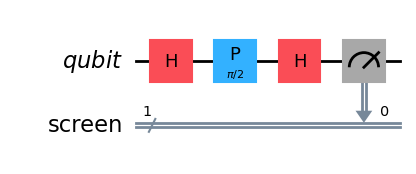

In [6]:
quantum_reg = QuantumRegister(1, name = 'qubit')
classical_reg = ClassicalRegister(1, name = 'screen')
# Lets create a new circuit
double_slit_with_phase = QuantumCircuit(quantum_reg, classical_reg)
double_slit_with_phase.h(0)
#Add a phase difference
double_slit_with_phase.p(np.pi / 2,0)
double_slit_with_phase.h(0)
double_slit_with_phase.measure(quantum_reg, classical_reg)
double_slit_with_phase.draw('mpl')

which is the same as previous circuit with just a phase there. LEt's run it

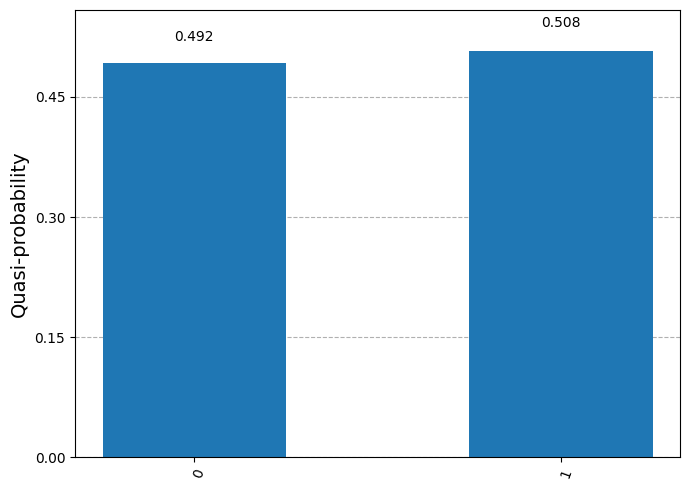

In [7]:
compiled_circuit = pass_manager.run(double_slit_with_phase)

sampler = Sampler(mode = backend)
counts = sampler.run([compiled_circuit], shots = 10000).result()[0].data.screen.get_counts()
plot_distribution(counts)

If we compare this plot with the previous one—where the probability of measuring state $\ket{0}$ was 1—we now observe that the probability has dropped to around $\sim$0.5. This indicates that the brightness on the screen will now begin to spread out, rather than being focused at a single point. We're done with this basic version of the experiment!

But wait — we’ve all seen the famous **fringe patterns** in our textbooks. Can we recreate that kind of interference pattern based on what we’ve built so far?

Let’s give it a try!

To visualize the full **interference fringe pattern**, we’ll now build a parameterized quantum circuit. Instead of fixing the phase difference, we’ll make it **variable** using a parameter $\phi$.

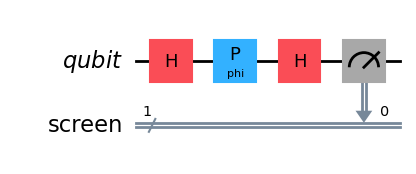

In [8]:
phi = Parameter('phi')

quantum_reg = QuantumRegister(1, name = "qubit")
classical_reg = ClassicalRegister(1, name = 'screen')

fringe_pattern = QuantumCircuit(quantum_reg, classical_reg)

fringe_pattern.h(quantum_reg[0])
fringe_pattern.p(phi, quantum_reg[0])
fringe_pattern.h(quantum_reg[0])
fringe_pattern.measure(quantum_reg[0], classical_reg[0])

fringe_pattern.draw('mpl')

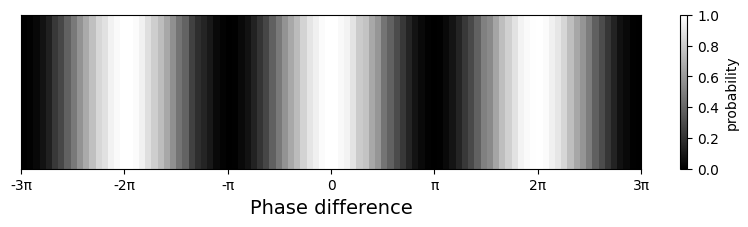

In [9]:
phi_lst = np.linspace(-3 * np.pi , 3 * np.pi, 100)
compiled_circuit = pass_manager.run(fringe_pattern)

phi_hit = []
distribution = sampler.run([(compiled_circuit, phi_lst)], shots=1000).result()[0].data.screen

for i in range(len(phi_lst)):
    result = distribution[i].get_counts()
    if '0' in result:
        phi_hit.append(result['0']/1000)
    else:
        phi_hit.append(0)
# plot the heat map

phi_hit_2d = np.array(phi_hit).reshape(1,-1)
plt.figure(figsize=(10,2))
plt.imshow(phi_hit_2d, cmap = 'grey', aspect = 'auto', extent =[-3*np.pi, 3*np.pi, 0, 0.1])

plt.xlabel('Phase difference', fontsize = 14)
plt.colorbar(label = 'probability')
plt.xticks(ticks=[-3*np.pi, -2*np.pi, -np.pi, 0, np.pi, 2*np.pi, 3*np.pi], labels=['-3π', '-2π', '-π', '0', 'π', '2π', '3π'])
plt.yticks([])  
plt.show()

We can now see clean and sharp fringes pattern !
### Now Let's Break the Interference!

Previously, we saw a clean interference pattern from the double-slit setup.

In the next cell, we'll modify the circuit by adding a **which-path detector** — a measurement after the first Hadamard gate. This mid-circuit measurement will collapse the superposition, and as a result, the interference pattern will vanish. In this case, we need two classical Registers, the one which will take measurement on screen(same as earlier) while the other which will act as detector. For this, what we'll do is to just measure our qubit right after applying the Hadamard gate. The measurement will break the superposition.

Let’s see how observing the qubit’s path changes everything.

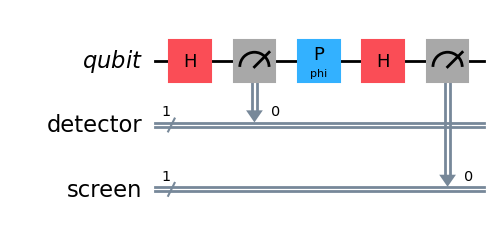

In [12]:
classical_reg_detector = ClassicalRegister(1, name = 'detector')

with_detector = QuantumCircuit(quantum_reg, classical_reg_detector, classical_reg)

phi = Parameter('phi')

with_detector.h(quantum_reg[0])
with_detector.measure(quantum_reg[0], classical_reg_detector[0])
with_detector.p(phi, quantum_reg[0])
with_detector.h(quantum_reg[0])
with_detector.measure(quantum_reg[0], classical_reg[0])

with_detector.draw('mpl')

Plot the heat map again with the same code

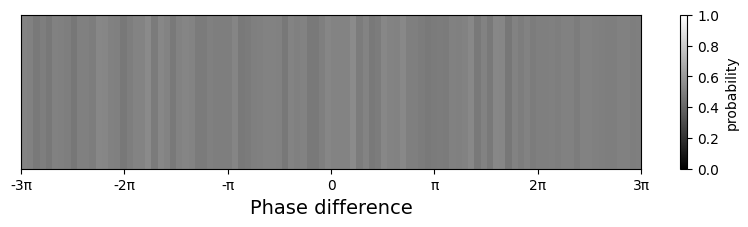

In [13]:
phi_lst = np.linspace(-3 * np.pi , 3 * np.pi, 100)
compiled_circuit = pass_manager.run(with_detector)

phi_hit = []
distribution = sampler.run([(compiled_circuit, phi_lst)], shots=1000).result()[0].data.screen

for i in range(len(phi_lst)):
    result = distribution[i].get_counts()
    if '0' in result:
        phi_hit.append(result['0']/1000)
    else:
        phi_hit.append(0)
# plot the heat map

phi_hit_2d = np.array(phi_hit).reshape(1,-1)
plt.figure(figsize=(10,2))
plt.imshow(phi_hit_2d, cmap = 'grey', aspect = 'auto', extent =[-3*np.pi, 3*np.pi, 0, 0.1], vmin = 0, vmax = 1)

plt.xlabel('Phase difference', fontsize = 14)
plt.colorbar(label = 'probability')
plt.xticks(ticks=[-3*np.pi, -2*np.pi, -np.pi, 0, np.pi, 2*np.pi, 3*np.pi], labels=['-3π', '-2π', '-π', '0', 'π', '2π', '3π'])
plt.yticks([])  
plt.show()

We can see, the fringes are disappeared...